<div align=center>

<font size=5>
    In the Name of God
<font/>
<br/>
<br/>
<font>
    Sharif University of Technology - Departmenet of Electrical Engineering
</font>
<br/>
<font>
    Introducing with Machine Learing - Dr. S. Amini
</font>
<br/>
<br/>
Spring 2023

</div>

<hr/>
<div align=center>
<font size=6>
    Neural Networks Practical Assignment
    
    Question 1
</font>
<br/>		
<font size=4>
<br/>
</div>

# Personal Data

In [135]:
# Set your student number
student_number = 99105901
Name = 'Amirhossein'
Last_Name = 'Akbari'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch. 

In [136]:
# !pip install numpy
# !pip install matplotlib
# !pip install torchvision
# !pip install torch

## Importing Libraries

In [137]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [138]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

In [139]:
image_shape = train_set[0][0].shape
input_dim = np.prod(image_shape).item()
num_classes = len(FashionMNIST.classes)

In [140]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)


## Visualization

Visualize 1 random image from each class

- **Hint**:  You can use `plt.subplots` for visualization

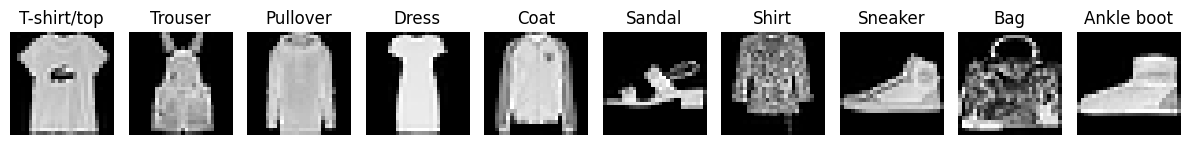

In [141]:

num_classes = len(train_set.classes)
fig, axes = plt.subplots(1, num_classes, figsize=(12, 3))


for class_idx in range(num_classes):

    indices = np.where(np.array(train_set.targets) == class_idx)[0]
    random_index = np.random.choice(indices)

    image, label = train_set[random_index]
    image = image.numpy().squeeze()

    axes[class_idx].imshow(image, cmap='gray')
    axes[class_idx].set_title(FashionMNIST.classes[label])
    axes[class_idx].axis('off')

plt.tight_layout()
plt.show()

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [142]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)
    w.requires_grad = True
    b.requires_grad = True
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [143]:
layers = [
    (input_dim, 128),
    (128, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [144]:
def affine_forward(x, w, b):
    return x @ w + b


def relu(x):
    return x * (x > 0)

Function `model` returns output of the whole model for the input `x` using the parameters:

In [145]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)
    
    out = x
    for i in range(num_layers):
        w = parameters[f'w{i}']
        b = parameters[f'b{i}']

        out = affine_forward(out, w, b)

        if i < num_layers - 1:
            out = relu(out)
    
    return out

Implementing cross entropy loss:

In [146]:
def cross_entropy_loss(scores, y):
    n = len(y)
    softmax_scores = torch.softmax(scores, dim=1)
    log_probs = torch.log(softmax_scores)
    loss = -torch.sum(log_probs[range(n), y]) / n
    return loss

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [147]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    for param in parameters.values():
        param.data -= learning_rate * param.grad
        param.grad.zero_()

Training functions:

In [148]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    """
    Computes the accuracy given the predicted labels and true labels.
    
    Arguments:
    y_pred -- numpy array of predicted labels
    y_true -- numpy array of true labels
    
    Returns:
    acc -- accuracy as a floating-point value between 0 and 1
    """
    correct = np.sum(y_pred == y_true)
    total = len(y_true)
    acc = correct / total
    return acc


def train(train_loader, learning_rate=0.001, epoch=None):
    train_loss = 0
    N = len(train_loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculating the accuracy later
    Y = []
    Y_pred = []

    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        loss = cross_entropy_loss(p, y)
        train_loss += loss.item()
        loss.backward()
        sgd_optimizer(parameters, learning_rate)

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

        print(f'Epoch: {epoch + 1}, Batch: {i+1}, Loss: {loss.item()}')

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    train_loss /= N
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of train set: {acc}')
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    total_loss = 0
    N = len(loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculating the accuracy later
    Y = []
    Y_pred = []

    for i, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        loss = cross_entropy_loss(p, y)
        total_loss += loss.item()

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

        print(f'Epoch: {epoch + 1}, Batch: {i+1}, Loss: {loss.item()}')

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    total_loss /= N
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    return total_loss, acc

In [149]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [150]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):
        train_loss, train_acc = train(train_loader, learning_rate, epoch)
        test_loss, test_acc = validate(test_loader, epoch, set_name='test')
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

    # Plot the loss history of training and test sets
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()
    plt.show()

    # Plot the accuracy history of training and test sets
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.legend()
    plt.show()

Epoch: 1, Batch: 1, Loss: 2.301133155822754
Epoch: 1, Batch: 2, Loss: 2.3006906509399414
Epoch: 1, Batch: 3, Loss: 2.3026561737060547
Epoch: 1, Batch: 4, Loss: 2.301496744155884
Epoch: 1, Batch: 5, Loss: 2.3034684658050537
Epoch: 1, Batch: 6, Loss: 2.301948070526123
Epoch: 1, Batch: 7, Loss: 2.3035051822662354
Epoch: 1, Batch: 8, Loss: 2.302046537399292
Epoch: 1, Batch: 9, Loss: 2.3029191493988037
Epoch: 1, Batch: 10, Loss: 2.302354097366333
Epoch: 1, Batch: 11, Loss: 2.3013253211975098
Epoch: 1, Batch: 12, Loss: 2.303168535232544
Epoch: 1, Batch: 13, Loss: 2.3012983798980713
Epoch: 1, Batch: 14, Loss: 2.3039066791534424
Epoch: 1, Batch: 15, Loss: 2.3019680976867676
Epoch: 1, Batch: 16, Loss: 2.303473949432373
Epoch: 1, Batch: 17, Loss: 2.2993767261505127
Epoch: 1, Batch: 18, Loss: 2.3035714626312256
Epoch: 1, Batch: 19, Loss: 2.3018949031829834
Epoch: 1, Batch: 20, Loss: 2.301424503326416
Epoch: 1, Batch: 21, Loss: 2.3031206130981445
Epoch: 1, Batch: 22, Loss: 2.30192232131958
Epoch: 

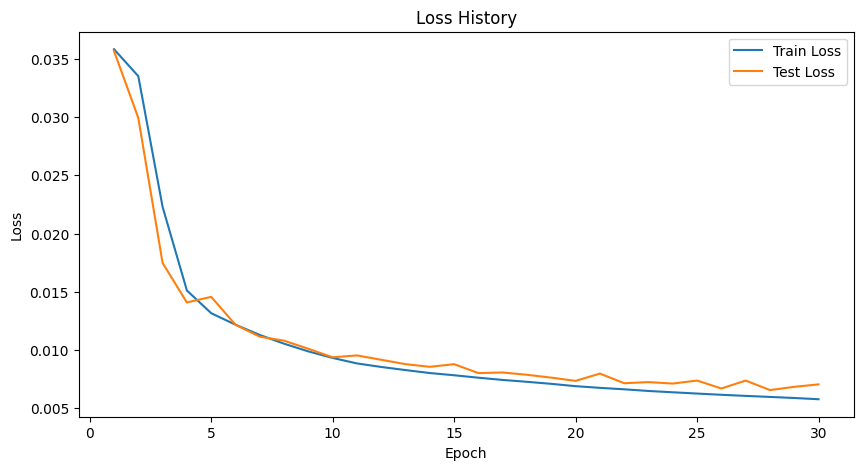

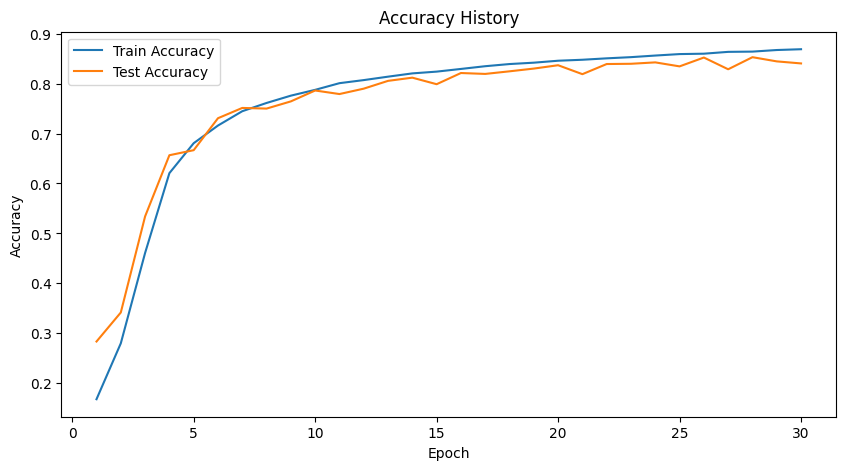

In [151]:
#Execute above cells first
train_model([train_loader, test_loader], num_epochs=30, learning_rate=0.005)

In [152]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.8404


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

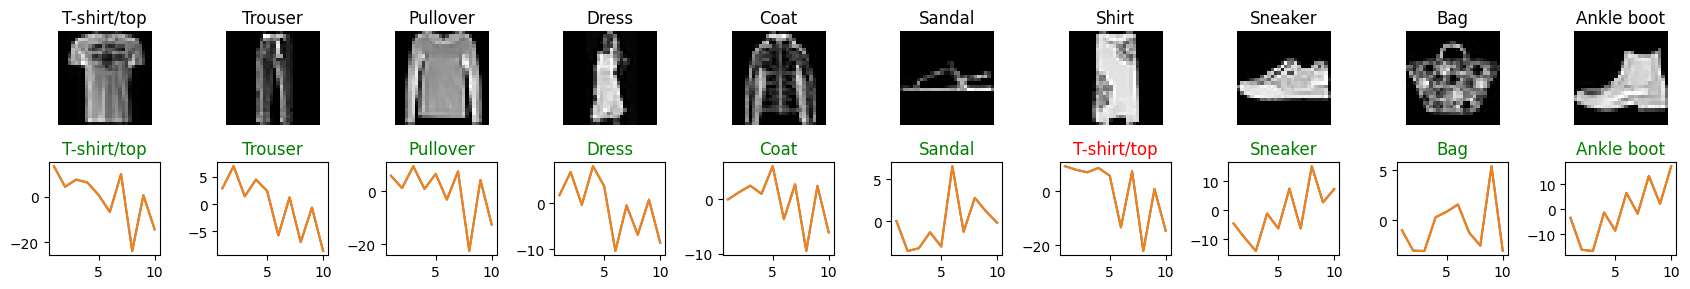

In [157]:
num_classes = len(test_set.classes)
fig, axes = plt.subplots(2, num_classes, figsize=(17, 3))

x_axis = np.arange(1, num_classes + 1)
for class_idx in range(num_classes):

    indices = np.where(np.array(test_set.targets) == class_idx)[0]
    random_index = np.random.choice(indices)

    image, label = test_set[random_index]
    modelOut = model(image, parameters).detach().numpy()
    prediction = np.argmax(modelOut)
    
    image = image.numpy().squeeze()

    axes[0,class_idx].imshow(image, cmap='gray')
    axes[0,class_idx].set_title(test_set.classes[label])
    axes[1,class_idx].set_title(test_set.classes[prediction])
    axes[0,class_idx].axis('off')
    axes[1,class_idx].plot(x_axis, modelOut.T)
    axes[1,class_idx].plot(x_axis, modelOut.T)
    if prediction != label :
        axes[1,class_idx].title.set_color('red')
    else:
        axes[1,class_idx].title.set_color('green')
plt.tight_layout()
plt.show()